In [83]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
import re
import nltk
import string
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


In [1]:
MACCROBAT_data_dir = "../data/MACCROBAT"

In [3]:
file_ids = []
for file in os.listdir(MACCROBAT_data_dir):
    file_id = file.split(".")[0]
    if file_id not in file_ids:
        file_ids.append(file_id)

In [4]:
tags = []
for ann_file in [os.path.join(MACCROBAT_data_dir, file_id+".ann") for file_id in file_ids]:
    with open(ann_file) as f:
        for line in f.readlines():
            tags.append(line.split("\t")[0][0])

set(tags)

{'#', '*', 'A', 'E', 'R', 'T'}

## How many unique words in the overall unstructured medical texts

In [5]:
word_counts = 0
for txt_file in [os.path.join(MACCROBAT_data_dir, file_id+".txt") for file_id in file_ids]:
    with open(txt_file, 'r') as f:
        text = f.read()
        word_counts += len(text.split())

word_counts


83404

In [27]:
command = "find {} -type f -name '*.txt' -exec wc -w {{}} + | tail -1".format(MACCROBAT_data_dir)
print("The total number of words is ", end="")
!{command}

The total number of words is    82872 total


In [26]:
command = "find {} -type f -name '*.txt' -exec cat {{}} \; | tr ' ' '\n' | sort -u | wc -l".format(MACCROBAT_data_dir)
print("The number of unique words is ", end="")
!{command}

The number of unique words is    15649


In [89]:
def clean_message(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = text.replace(".", " ")

    text = "".join([c for c in text if c not in string.punctuation])
    text = " ".join([word for word in re.split('\W+', text) 
                               if word not in stopwords.words('english')])
    wn = nltk.WordNetLemmatizer()    
    text = " ".join([wn.lemmatize(word, 'r') for word in re.split('\W+', text)])
    return text   
vocab = []
for txt_file in [os.path.join(MACCROBAT_data_dir, file_id+".txt") for file_id in file_ids]:
    with open(txt_file, 'r') as f:
        text = f.read()
    text = clean_message(text)
    words = text.split()
    vocab.extend(words)

In [91]:
set(vocab)

{'paravertebral',
 'amikacin',
 'vater',
 'beatsmin',
 'continues',
 'activated',
 'hypothermic',
 'release',
 '8256',
 'intervening',
 'reasons',
 'fish',
 'iuml',
 'pamidronate',
 'pork',
 'amino',
 'lmin',
 'traveling',
 '24hour',
 'pairs',
 '58',
 'paroxysms',
 'neurophysiological',
 'measures',
 'hemoperitoneum',
 'suppositories',
 'ringed',
 'colonic',
 'myeloma',
 '0900',
 'hypoechoic',
 'woven',
 'explain',
 'atenolol',
 'rifampicin',
 'distributed',
 'drooping',
 'partners',
 'tempe',
 'blocking',
 'twoandahalf',
 'hypotensive',
 '2cd',
 'maintained',
 'dystonic',
 '8856',
 'prick',
 'radiotherapeutic',
 'targeting',
 'imrt',
 'ephedrine',
 'depicted',
 'cavitations',
 'unfractionated',
 'bruits',
 'breach',
 '1800mgm2',
 'epstein',
 'ectodermal',
 'laughter',
 'antissa',
 'bronchoscopic',
 'ensured',
 'steroids',
 'hysteroscopy',
 'maneuver',
 'bacteriological',
 'anatomic',
 'thickness',
 'spontaneously',
 'cupped',
 'ngmlh',
 'triphosphate',
 'itba',
 'confluent',
 'length'

In [341]:
df_list = []
for ann_file in [os.path.join(MACCROBAT_data_dir, file_id+".ann") for file_id in file_ids]:
    # read the TSV file with consecutive tabs treated as a single delimiter
    df = pd.read_csv(ann_file, sep="\t+", header=None, names=['id', 'entity_with_range', 'word'], engine='python')

    # selecting only T tag rows
    df = df[df.iloc[:,0].str.startswith('T')]

    df['file_name'] = f"{os.path.splitext(ann_file)[0]}.txt"

    df_list.append(df)

ann_df = pd.concat(df_list)
ann_df = ann_df.reset_index(drop=True)

In [342]:
ann_df.head()

,id,entity_with_range,word,file_name
0,T1,Age 4 15,24-year-old,../data/MACCROBAT/19860925.txt
1,T2,Sex 28 32,male,../data/MACCROBAT/19860925.txt
2,T3,History 16 27,non-smoking,../data/MACCROBAT/19860925.txt
3,T4,Clinical_event 41 50,presented,../data/MACCROBAT/19860925.txt
4,T5,Sign_symptom 65 75,hemoptysis,../data/MACCROBAT/19860925.txt


In [343]:
ann_df['entity'] = ann_df['entity_with_range'].str.split().str[0]
ann_df['ranges'] = ann_df['entity_with_range'].str.split().str[1:]
ann_df = ann_df[['id', 'entity', 'ranges', 'word', 'file_name']]
ann_df.head()

,id,entity,ranges,word,file_name
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt


In [344]:
ann_df.entity.unique()

array(['Age', 'Sex', 'History', 'Clinical_event', 'Sign_symptom',
       'Detailed_description', 'Date', 'Duration', 'Biological_structure',
       'Personal_background', 'Severity', 'Coreference', 'Texture',
       'Diagnostic_procedure', 'Area', 'Disease_disorder', 'Lab_value',
       'Therapeutic_procedure', 'Distance', 'Medication', 'Dosage',
       'Shape', 'Administration', 'Nonbiological_location',
       'Qualitative_concept', 'Frequency', 'Outcome', 'Activity',
       'Subject', 'Quantitative_concept', 'Volume', 'Color',
       'Other_event', 'Time', 'Family_history', 'Biological_attribute',
       'Height', 'Mass', 'Occupation', 'Weight', 'Other_entity'],
      dtype=object)

In [345]:
print(f"The total number of unique entities is {ann_df.entity.nunique()}")

The total number of unique entities is 41


In [346]:
ann_df.groupby('file_name')['entity'].nunique().min(), ann_df.groupby('file_name')['entity'].nunique().max()

(12, 27)

In [347]:
ann_df.groupby('entity')['file_name'].nunique().min(), ann_df.groupby('entity')['file_name'].nunique().max()

(2, 200)

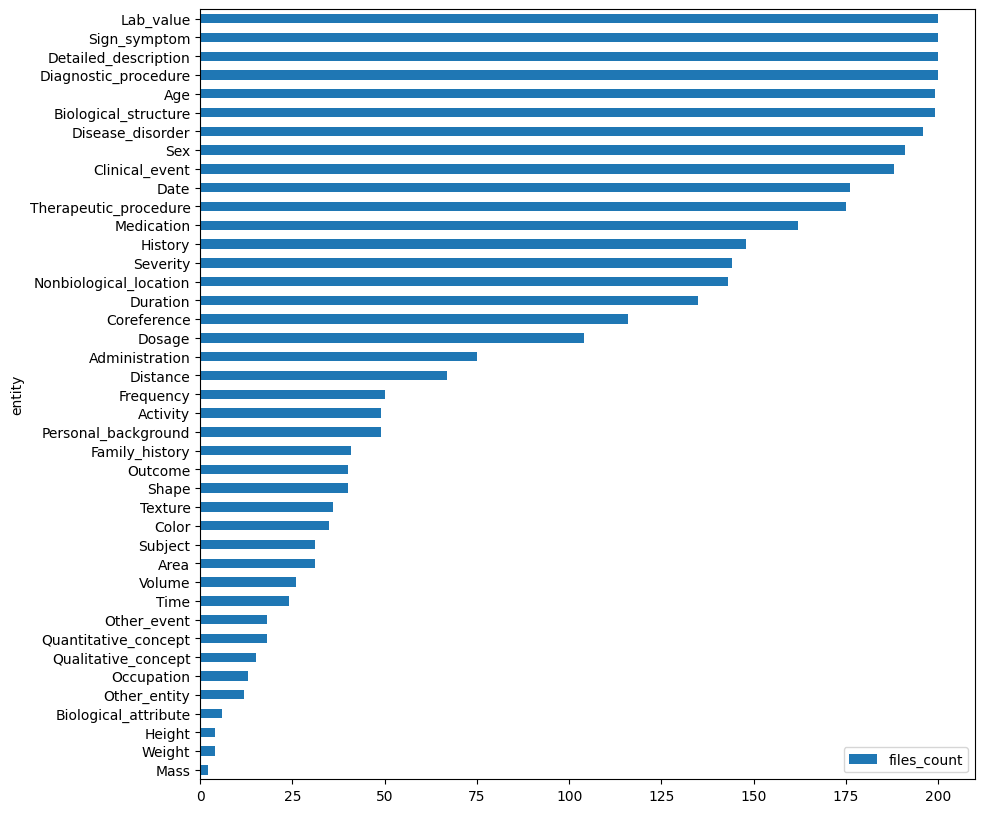

In [348]:
ann_df.groupby('entity')['file_name'].nunique().to_frame(name="files_count").sort_values(by="files_count").plot.barh(figsize=(10, 10))
plt.show()

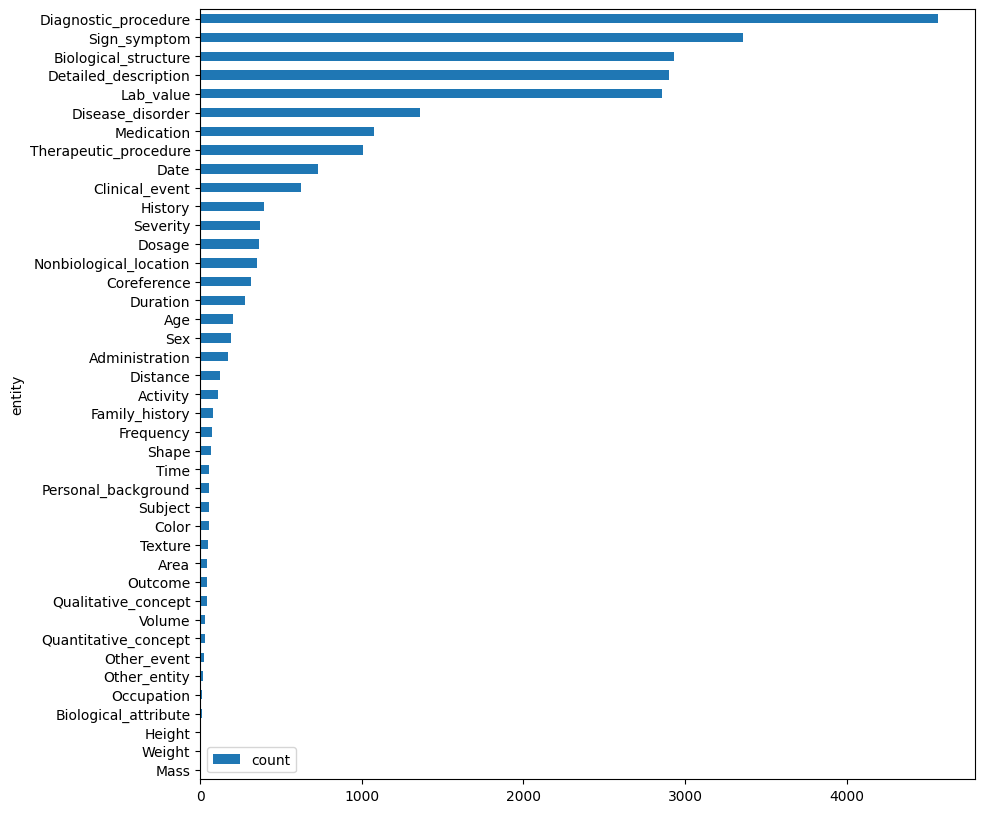

In [349]:
ann_df.groupby('entity')['file_name'].size().to_frame(name="count").sort_values(by="count").plot.barh(figsize=(10, 10))
plt.show()

In [350]:
ann_df.shape

(25041, 5)

In [351]:
ann_df[ann_df['ranges'].apply(len) > 2]

,id,entity,ranges,word,file_name
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt
1469,T101,Detailed_description,"[2552, 2559;2585, 2654]",neither had developed any signs or symptoms su...,../data/MACCROBAT/28353558.txt
2376,T42,Administration,"[704, 715;721, 726]",intravenous bolus,../data/MACCROBAT/23124805.txt
2380,T47,Dosage,"[828, 835;861, 879]",5 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt
2381,T48,Dosage,"[849, 857;861, 879]",10 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt
2853,T18,Diagnostic_procedure,"[341, 350;357, 358]",Hepatitis C,../data/MACCROBAT/18416479.txt
3335,T16,Disease_disorder,"[315, 317;319, 330]",LV dysfunction,../data/MACCROBAT/23468586.txt
3336,T15,Disease_disorder,"[297, 313;319, 330]",left ventricular dysfunction,../data/MACCROBAT/23468586.txt


In [352]:
ann_df[['word', 'file_name']].nunique()

word         13056
file_name      200
dtype: int64

In [353]:
ann_df[ann_df[['word', 'file_name']].duplicated()]

,id,entity,ranges,word,file_name
18,T19,Coreference,"[293, 298]",cough,../data/MACCROBAT/19860925.txt
20,T21,Severity,"[282, 288]",strong,../data/MACCROBAT/19860925.txt
35,T36,Coreference,"[599, 603]",mass,../data/MACCROBAT/19860925.txt
50,T51,Coreference,"[983, 993]",hemothorax,../data/MACCROBAT/19860925.txt
53,T54,Sign_symptom,"[1010, 1025]",malignant cells,../data/MACCROBAT/19860925.txt
...,...,...,...,...,...
25023,T121,Detailed_description,"[3195, 3205]",left-sided,../data/MACCROBAT/26714786.txt
25025,T123,Clinical_event,"[3321, 3330]",follow-up,../data/MACCROBAT/26714786.txt
25027,T125,Diagnostic_procedure,"[3345, 3355]",hemoglobin,../data/MACCROBAT/26714786.txt
25029,T127,Therapeutic_procedure,"[3402, 3414]",transfusions,../data/MACCROBAT/26714786.txt


In [354]:
ann_df[ann_df[['word', 'ranges', 'file_name']].apply(lambda x: tuple(x), axis=1).duplicated()]

,id,entity,ranges,word,file_name
76,T6,History,"[69, 81]",hypertension,../data/MACCROBAT/26361640.txt
1028,T5,Disease_disorder,"[128, 143]",Crohn's disease,../data/MACCROBAT/28154700.txt
1198,T47,History,"[256, 265]",histology,../data/MACCROBAT/20146086.txt
1758,T4,History,"[67, 79]",hypertension,../data/MACCROBAT/26309459.txt
1761,T7,History,"[84, 99]",type 2 diabetes,../data/MACCROBAT/26309459.txt
...,...,...,...,...,...
22841,T15,Disease_disorder,"[293, 302]",gastritis,../data/MACCROBAT/27004009.txt
23864,T109,Therapeutic_procedure,"[2419, 2439]",postoperative course,../data/MACCROBAT/22520024.txt
23868,T113,History,"[539, 557]",additional therapy,../data/MACCROBAT/22520024.txt
24371,T25,History,"[339, 365]",glucocorticoid replacement,../data/MACCROBAT/27749582.txt


In [355]:
ann_df['ranges'][0]

['4', '15']

In [356]:
def fix_ranges_col(ranges):

    new_ranges_list = []
    if len(ranges) > 2:
        start = ranges[0]
        for idx in range(1, len(ranges)):
            try:
                end, next_start = ranges[idx].split(';')
            except ValueError:
                end = ranges[idx]
            new_ranges_list.append([int(start), int(end)])
            start = next_start
    else:
        new_ranges_list = list(map(int, ranges))
    return new_ranges_list
    
ann_df['ranges_fixed'] = ann_df['ranges'].apply(lambda x: fix_ranges_col(x))

In [357]:
ann_df.head()

,id,entity,ranges,word,file_name,ranges_fixed
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]"
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt,"[28, 32]"
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]"
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt,"[41, 50]"
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]"


In [358]:
for i in ann_df.ranges_fixed:
    if isinstance(i[0], list):
        print(i)

[[701, 714], [730, 735]]
[[4085, 4093], [4103, 4108]]
[[3117, 3124], [3135, 3141]]
[[2552, 2559], [2585, 2654]]
[[704, 715], [721, 726]]
[[828, 835], [861, 879]]
[[849, 857], [861, 879]]
[[341, 350], [357, 358]]
[[315, 317], [319, 330]]
[[297, 313], [319, 330]]
[[606, 621], [641, 647]]
[[1017, 1032], [1052, 1058]]
[[1316, 1318], [1328, 1336]]
[[1386, 1391], [1408, 1412]]
[[606, 621], [641, 647]]
[[2001, 2005], [2034, 2037]]
[[2114, 2133], [2139, 2143]]
[[2428, 2438], [2444, 2463]]
[[2428, 2438], [2472, 2499]]
[[535, 538], [546, 550]]
[[2015, 2024], [2052, 2061]]
[[1644, 1653], [1673, 1684]]
[[474, 481], [490, 503]]
[[2831, 2851], [2858, 2859]]
[[2637, 2653], [2667, 2674]]
[[2296, 2320], [2327, 2335]]
[[2362, 2371], [2375, 2377]]
[[2362, 2371], [2383, 2386]]
[[1366, 1373], [1386, 1404]]
[[1596, 1600], [1628, 1631]]
[[1657, 1661], [1690, 1693]]
[[2306, 2308], [2316, 2323]]
[[1557, 1559], [1560, 1567]]
[[2186, 2188], [2189, 2196]]
[[2427, 2429], [2430, 2437]]
[[1746, 1813], [1814, 1845], 

In [359]:
ann_df[ann_df['ranges_fixed'].apply(lambda x: isinstance(x[0], list))]

,id,entity,ranges,word,file_name,ranges_fixed
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[[701, 714], [730, 735]]"
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[[4085, 4093], [4103, 4108]]"
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt,"[[3117, 3124], [3135, 3141]]"
1469,T101,Detailed_description,"[2552, 2559;2585, 2654]",neither had developed any signs or symptoms su...,../data/MACCROBAT/28353558.txt,"[[2552, 2559], [2585, 2654]]"
2376,T42,Administration,"[704, 715;721, 726]",intravenous bolus,../data/MACCROBAT/23124805.txt,"[[704, 715], [721, 726]]"
2380,T47,Dosage,"[828, 835;861, 879]",5 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt,"[[828, 835], [861, 879]]"
2381,T48,Dosage,"[849, 857;861, 879]",10 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt,"[[849, 857], [861, 879]]"
2853,T18,Diagnostic_procedure,"[341, 350;357, 358]",Hepatitis C,../data/MACCROBAT/18416479.txt,"[[341, 350], [357, 358]]"
3335,T16,Disease_disorder,"[315, 317;319, 330]",LV dysfunction,../data/MACCROBAT/23468586.txt,"[[315, 317], [319, 330]]"
3336,T15,Disease_disorder,"[297, 313;319, 330]",left ventricular dysfunction,../data/MACCROBAT/23468586.txt,"[[297, 313], [319, 330]]"


In [360]:
ann_df.shape

(25041, 6)

In [361]:
ann_df['ismulti_dim'] = 0

In [362]:
ann_df.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt,"[28, 32]",0
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0


In [363]:
ann_df.loc[
    ann_df['ranges_fixed'].apply(lambda x: isinstance(x[0], list)), 
    'ismulti_dim'
] = 1

In [364]:
ann_df.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt,"[28, 32]",0
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0


In [365]:
ann_df[ann_df['ranges_fixed'].apply(lambda x: isinstance(x[0], list))]

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[[701, 714], [730, 735]]",1
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[[4085, 4093], [4103, 4108]]",1
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt,"[[3117, 3124], [3135, 3141]]",1
1469,T101,Detailed_description,"[2552, 2559;2585, 2654]",neither had developed any signs or symptoms su...,../data/MACCROBAT/28353558.txt,"[[2552, 2559], [2585, 2654]]",1
2376,T42,Administration,"[704, 715;721, 726]",intravenous bolus,../data/MACCROBAT/23124805.txt,"[[704, 715], [721, 726]]",1
2380,T47,Dosage,"[828, 835;861, 879]",5 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt,"[[828, 835], [861, 879]]",1
2381,T48,Dosage,"[849, 857;861, 879]",10 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt,"[[849, 857], [861, 879]]",1
2853,T18,Diagnostic_procedure,"[341, 350;357, 358]",Hepatitis C,../data/MACCROBAT/18416479.txt,"[[341, 350], [357, 358]]",1
3335,T16,Disease_disorder,"[315, 317;319, 330]",LV dysfunction,../data/MACCROBAT/23468586.txt,"[[315, 317], [319, 330]]",1
3336,T15,Disease_disorder,"[297, 313;319, 330]",left ventricular dysfunction,../data/MACCROBAT/23468586.txt,"[[297, 313], [319, 330]]",1


In [366]:
multi_dim_df = ann_df[ann_df['ismulti_dim'] == 1]
multi_dim_df.shape

(55, 7)

In [367]:
one_dim_df = ann_df[ann_df['ismulti_dim'] == 0]
one_dim_df.shape

(24986, 7)

In [368]:
one_dim_df.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt,"[28, 32]",0
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0


explode multi_dim ranges rows

In [369]:
multi_dim_df.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[[701, 714], [730, 735]]",1
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[[4085, 4093], [4103, 4108]]",1
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt,"[[3117, 3124], [3135, 3141]]",1
1469,T101,Detailed_description,"[2552, 2559;2585, 2654]",neither had developed any signs or symptoms su...,../data/MACCROBAT/28353558.txt,"[[2552, 2559], [2585, 2654]]",1
2376,T42,Administration,"[704, 715;721, 726]",intravenous bolus,../data/MACCROBAT/23124805.txt,"[[704, 715], [721, 726]]",1


In [370]:
multi_dim_df = multi_dim_df.explode('ranges_fixed')
multi_dim_df.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[701, 714]",1
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[730, 735]",1
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[4085, 4093]",1
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[4103, 4108]",1
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt,"[3117, 3124]",1


In [371]:
multi_dim_df.shape

(114, 7)

In [372]:
multi_dim_df.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[701, 714]",1
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[730, 735]",1
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[4085, 4093]",1
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[4103, 4108]",1
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt,"[3117, 3124]",1


In [373]:
ann_df_fixed = pd.concat([one_dim_df, multi_dim_df], axis=0)
ann_df_fixed.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt,"[28, 32]",0
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0


In [374]:
ann_df_fixed.shape

(25100, 7)

In [375]:
ann_df_fixed[ann_df_fixed['ranges_fixed'].apply(lambda x: isinstance(x[0], list))]

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim


,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",NaN


In [376]:
def extract_word_for_range(file_name, start_end):
    with open(file_name, 'r') as f:
        text = f.read()
    start = int(start_end[0])
    end = int(start_end[1])
    
    return text[start:end]
    
ann_df_fixed['token'] = ann_df_fixed.apply(lambda row: extract_word_for_range(row['file_name'], row['ranges_fixed']), axis=1)

In [382]:
ann_df_fixed[
    (ann_df_fixed['word'] != ann_df_fixed['token']) &
    (ann_df_fixed['ismulti_dim'] == 1)
]

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim,token
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[701, 714]",1,granular cell
39,T40,Disease_disorder,"[701, 714;730, 735]",granular cell tumor,../data/MACCROBAT/19860925.txt,"[730, 735]",1,tumor
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[4085, 4093]",1,low dose
1190,T31,Dosage,"[4085, 4093;4103, 4108]",low dose daily,../data/MACCROBAT/20146086.txt,"[4103, 4108]",1,daily
1272,T160,Dosage,"[3117, 3124;3135, 3141]",1500 mg weekly,../data/MACCROBAT/20146086.txt,"[3117, 3124]",1,1500 mg
...,...,...,...,...,...,...,...,...
22069,T75,Sign_symptom,"[1994, 2004;2021, 2029]",perineural invasion,../data/MACCROBAT/19610147.txt,"[2021, 2029]",1,invasion
22621,T35,Biological_structure,"[900, 905;915, 918]",right eye,../data/MACCROBAT/26692730.txt,"[900, 905]",1,right
22621,T35,Biological_structure,"[900, 905;915, 918]",right eye,../data/MACCROBAT/26692730.txt,"[915, 918]",1,eye
22623,T37,Lab_value,"[926, 929;938, 939]",561 μ,../data/MACCROBAT/26692730.txt,"[926, 929]",1,561


In [383]:
ann_df_fixed['start'] = ann_df_fixed['ranges_fixed'].apply(lambda x: x[0])
ann_df_fixed['end'] = ann_df_fixed['ranges_fixed'].apply(lambda x: x[1])

In [384]:
ann_df_fixed.head()

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim,token,start,end
0,T1,Age,"[4, 15]",24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-old,4,15
1,T2,Sex,"[28, 32]",male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,male,28,32
2,T3,History,"[16, 27]",non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smoking,16,27
3,T4,Clinical_event,"[41, 50]",presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presented,41,50
4,T5,Sign_symptom,"[65, 75]",hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysis,65,75


In [387]:
ann_df_fixed.sort_values(by=['file_name', 'start'])

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim,token,start,end
15588,T1,Age,"[8, 19]",28-year-old,../data/MACCROBAT/15939911.txt,"[8, 19]",0,28-year-old,8,19
15589,T2,History,"[20, 38]",previously healthy,../data/MACCROBAT/15939911.txt,"[20, 38]",0,previously healthy,20,38
15592,T5,Sign_symptom,"[31, 38]",healthy,../data/MACCROBAT/15939911.txt,"[31, 38]",0,healthy,31,38
15590,T3,Sex,"[39, 42]",man,../data/MACCROBAT/15939911.txt,"[39, 42]",0,man,39,42
15591,T4,Clinical_event,"[43, 52]",presented,../data/MACCROBAT/15939911.txt,"[43, 52]",0,presented,43,52
...,...,...,...,...,...,...,...,...,...,...
21976,T90,Diagnostic_procedure,"[2324, 2343]",coagulation routine,../data/MACCROBAT/28767567.txt,"[2324, 2343]",0,coagulation routine,2324,2343
21977,T91,Diagnostic_procedure,"[2349, 2364]",ultrasound scan,../data/MACCROBAT/28767567.txt,"[2349, 2364]",0,ultrasound scan,2349,2364
21978,T92,Date,"[2368, 2375]",30 days,../data/MACCROBAT/28767567.txt,"[2368, 2375]",0,30 days,2368,2375
21979,T93,Sign_symptom,"[2394, 2405]",abnormality,../data/MACCROBAT/28767567.txt,"[2394, 2405]",0,abnormality,2394,2405


In [391]:
ann_df_fixed.dtypes

id              object
entity          object
ranges          object
word            object
file_name       object
ranges_fixed    object
ismulti_dim      int64
token           object
start            int64
end              int64
dtype: object

In [393]:
ann_df_fixed[
    (ann_df_fixed['file_name'] == '../data/MACCROBAT/23124805.txt') &
    (ann_df_fixed['entity'] == 'Dosage') &
    (ann_df_fixed['token'] == 'every 4 to 6 weeks') &
    (ann_df_fixed['start'] == 861) &
    (ann_df_fixed['end'] == 879) 
]


,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim,token,start,end
2380,T47,Dosage,"[828, 835;861, 879]",5 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt,"[861, 879]",1,every 4 to 6 weeks,861,879
2381,T48,Dosage,"[849, 857;861, 879]",10 mg/kg every 4 to 6 weeks,../data/MACCROBAT/23124805.txt,"[861, 879]",1,every 4 to 6 weeks,861,879


In [399]:
ann_df_fixed[['file_name', 'entity', 'token', 'start', 'end']].shape

(25100, 5)

In [400]:
ann_df_fixed[['file_name', 'entity', 'token', 'start', 'end']].drop_duplicates().shape

(25092, 5)

In [413]:
col_list = ['file_name', 'entity', 'token', 'start', 'end']

ann_df_fixed[ann_df_fixed[col_list].duplicated()][col_list]

,file_name,entity,token,start,end
2381,../data/MACCROBAT/23124805.txt,Dosage,every 4 to 6 weeks,861,879
3336,../data/MACCROBAT/23468586.txt,Disease_disorder,dysfunction,319,330
4655,../data/MACCROBAT/19214295.txt,Biological_structure,origins of,2428,2438
11589,../data/MACCROBAT/21308977.txt,Diagnostic_procedure,complexes,2362,2371
17850,../data/MACCROBAT/25210224.txt,Biological_structure,mandibular,1101,1111
17896,../data/MACCROBAT/25210224.txt,Biological_structure,cochlea,2873,2880
20499,../data/MACCROBAT/19307547.txt,Time,minutes,477,484
20592,../data/MACCROBAT/19307547.txt,Biological_structure,homogenates,2559,2570


In [227]:
ann_df_fixed[ann_df_fixed[['word', 'ranges_fixed', 'file_name']].apply(lambda x: tuple(x), axis=1).duplicated()]

,id,entity,ranges,word,file_name,ranges_fixed,start,end
76,T6,History,"[69, 81]",hypertension,../data/MACCROBAT/26361640.txt,"[69, 81]",69,81
1028,T5,Disease_disorder,"[128, 143]",Crohn's disease,../data/MACCROBAT/28154700.txt,"[128, 143]",128,143
1198,T47,History,"[256, 265]",histology,../data/MACCROBAT/20146086.txt,"[256, 265]",256,265
1758,T4,History,"[67, 79]",hypertension,../data/MACCROBAT/26309459.txt,"[67, 79]",67,79
1761,T7,History,"[84, 99]",type 2 diabetes,../data/MACCROBAT/26309459.txt,"[84, 99]",84,99
...,...,...,...,...,...,...,...,...
23868,T113,History,"[539, 557]",additional therapy,../data/MACCROBAT/22520024.txt,"[539, 557]",539,557
24371,T25,History,"[339, 365]",glucocorticoid replacement,../data/MACCROBAT/27749582.txt,"[339, 365]",339,365
24379,T33,History,"[539, 557]",nephrotic syndrome,../data/MACCROBAT/27749582.txt,"[539, 557]",539,557
3405,T86,History,"[606, 621;641, 647]",total carnitine levels,../data/MACCROBAT/23468586.txt,"[606, 621]",606,621


In [243]:
ann_df_fixed[ann_df_fixed[['start', 'end', 'word', 'file_name']].duplicated()]

,id,entity,ranges,word,file_name,ranges_fixed,start,end
76,T6,History,"[69, 81]",hypertension,../data/MACCROBAT/26361640.txt,"[69, 81]",69,81
1028,T5,Disease_disorder,"[128, 143]",Crohn's disease,../data/MACCROBAT/28154700.txt,"[128, 143]",128,143
1198,T47,History,"[256, 265]",histology,../data/MACCROBAT/20146086.txt,"[256, 265]",256,265
1758,T4,History,"[67, 79]",hypertension,../data/MACCROBAT/26309459.txt,"[67, 79]",67,79
1761,T7,History,"[84, 99]",type 2 diabetes,../data/MACCROBAT/26309459.txt,"[84, 99]",84,99
...,...,...,...,...,...,...,...,...
23868,T113,History,"[539, 557]",additional therapy,../data/MACCROBAT/22520024.txt,"[539, 557]",539,557
24371,T25,History,"[339, 365]",glucocorticoid replacement,../data/MACCROBAT/27749582.txt,"[339, 365]",339,365
24379,T33,History,"[539, 557]",nephrotic syndrome,../data/MACCROBAT/27749582.txt,"[539, 557]",539,557
3405,T86,History,"[606, 621;641, 647]",total carnitine levels,../data/MACCROBAT/23468586.txt,"[606, 621]",606,621


In [425]:
ann_df_fixed['token_length'] = ann_df_fixed['token'].str.len()

In [427]:
ann_df_fixed[ann_df_fixed['token_length'] != (ann_df_fixed['end'] - ann_df_fixed['start'])]

,id,entity,ranges,word,file_name,ranges_fixed,ismulti_dim,token,start,end,token_length


In [430]:
ann_df_fixed.drop('ranges', axis=1, inplace=True)
ann_df_fixed.head()

,id,entity,word,file_name,ranges_fixed,ismulti_dim,token,start,end,token_length
0,T1,Age,24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-old,4,15,11
1,T2,Sex,male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,male,28,32,4
2,T3,History,non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smoking,16,27,11
3,T4,Clinical_event,presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presented,41,50,9
4,T5,Sign_symptom,hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysis,65,75,10


In [432]:
ann_df_fixed = ann_df_fixed.rename(columns={
    'ranges_fixed':'ranges'
})
ann_df_fixed.head()

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,token_length
0,T1,Age,24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-old,4,15,11
1,T2,Sex,male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,male,28,32,4
2,T3,History,non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smoking,16,27,11
3,T4,Clinical_event,presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presented,41,50,9
4,T5,Sign_symptom,hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysis,65,75,10


In [433]:
ann_df_fixed.drop('token_length', axis=1, inplace=True)
ann_df_fixed.head()

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end
0,T1,Age,24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-old,4,15
1,T2,Sex,male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,male,28,32
2,T3,History,non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smoking,16,27
3,T4,Clinical_event,presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presented,41,50
4,T5,Sign_symptom,hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysis,65,75


In [450]:
ann_df_fixed.head()

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end
0,T1,Age,24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-old,4,15
1,T2,Sex,male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,male,28,32
2,T3,History,non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smoking,16,27
3,T4,Clinical_event,presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presented,41,50
4,T5,Sign_symptom,hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysis,65,75


In [462]:
get_new_range_by_splitting_token('low dose daily', 4085, 4093)

[[4085, 4087], [4089, 4092], [4094, 4098]]

In [466]:
def get_new_range_by_splitting_token(token, start, end):
    
    new_range = []
    curr = start
    new_start = None
    for c in token+ " ":
        if c == ' ':
            if new_start:
                new_range.append([new_start, curr])
                new_start = None
        elif not new_start:
            new_start = curr
        curr += 1
    
    if len(new_range) == 1:
        new_range = new_range[0]
    return new_range

ann_df_fixed['new_range'] = ann_df_fixed.apply(lambda row: get_new_range_by_splitting_token(row['token'], row['start'], row['end']), axis=1)    




In [467]:
ann_df_fixed[ann_df_fixed['new_range'].apply(lambda x: isinstance(x[0], list))]

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,new_range
6,T7,Date,May 2008,../data/MACCROBAT/19860925.txt,"[79, 87]",0,May 2008,79,87,"[[79, 81], [83, 86]]"
7,T8,Duration,4 days,../data/MACCROBAT/19860925.txt,"[93, 99]",0,4 days,93,99,"[[93, 93], [95, 98]]"
9,T10,Biological_structure,right thoracic,../data/MACCROBAT/19860925.txt,"[115, 129]",0,right thoracic,115,129,"[[115, 119], [121, 128]]"
10,T11,Detailed_description,which intensified while breathing,../data/MACCROBAT/19860925.txt,"[135, 168]",0,which intensified while breathing,135,168,"[[135, 139], [141, 151], [153, 157], [159, 167]]"
12,T13,History,holidays in his home country,../data/MACCROBAT/19860925.txt,"[177, 205]",0,holidays in his home country,177,205,"[[177, 184], [186, 187], [189, 191], [193, 196..."
...,...,...,...,...,...,...,...,...,...,...
17808,T163,Other_entity,and we recommended no further exposure to lead...,../data/MACCROBAT/27661040.txt,"[4047, 4155]",1,and we recommended no further exposure to lead...,4047,4155,"[[4047, 4049], [4051, 4052], [4054, 4064], [40..."
17808,T163,Other_entity,and we recommended no further exposure to lead...,../data/MACCROBAT/27661040.txt,"[4156, 4238]",1,The long-term outcome of this case depends on ...,4156,4238,"[[4156, 4158], [4160, 4168], [4170, 4176], [41..."
17856,T46,Lab_value,shorter than the other side,../data/MACCROBAT/25210224.txt,"[1457, 1476]",1,than the other side,1457,1476,"[[1457, 1460], [1462, 1464], [1466, 1470], [14..."
18823,T51,Date,age of 44,../data/MACCROBAT/28595573.txt,"[1251, 1257]",1,age of,1251,1257,"[[1251, 1253], [1255, 1256]]"


In [469]:
ann_df_fixed['ismulti_dim'] = 0

In [470]:
ann_df_fixed.loc[
    ann_df_fixed['new_range'].apply(lambda x: isinstance(x[0], list)), 
    'ismulti_dim'
] = 1

In [472]:
ann_df_fixed[ann_df_fixed['ismulti_dim'] == 1]

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,new_range
6,T7,Date,May 2008,../data/MACCROBAT/19860925.txt,"[79, 87]",1,May 2008,79,87,"[[79, 81], [83, 86]]"
7,T8,Duration,4 days,../data/MACCROBAT/19860925.txt,"[93, 99]",1,4 days,93,99,"[[93, 93], [95, 98]]"
9,T10,Biological_structure,right thoracic,../data/MACCROBAT/19860925.txt,"[115, 129]",1,right thoracic,115,129,"[[115, 119], [121, 128]]"
10,T11,Detailed_description,which intensified while breathing,../data/MACCROBAT/19860925.txt,"[135, 168]",1,which intensified while breathing,135,168,"[[135, 139], [141, 151], [153, 157], [159, 167]]"
12,T13,History,holidays in his home country,../data/MACCROBAT/19860925.txt,"[177, 205]",1,holidays in his home country,177,205,"[[177, 184], [186, 187], [189, 191], [193, 196..."
...,...,...,...,...,...,...,...,...,...,...
17808,T163,Other_entity,and we recommended no further exposure to lead...,../data/MACCROBAT/27661040.txt,"[4047, 4155]",1,and we recommended no further exposure to lead...,4047,4155,"[[4047, 4049], [4051, 4052], [4054, 4064], [40..."
17808,T163,Other_entity,and we recommended no further exposure to lead...,../data/MACCROBAT/27661040.txt,"[4156, 4238]",1,The long-term outcome of this case depends on ...,4156,4238,"[[4156, 4158], [4160, 4168], [4170, 4176], [41..."
17856,T46,Lab_value,shorter than the other side,../data/MACCROBAT/25210224.txt,"[1457, 1476]",1,than the other side,1457,1476,"[[1457, 1460], [1462, 1464], [1466, 1470], [14..."
18823,T51,Date,age of 44,../data/MACCROBAT/28595573.txt,"[1251, 1257]",1,age of,1251,1257,"[[1251, 1253], [1255, 1256]]"


In [473]:
multi_dim_df = ann_df_fixed[ann_df_fixed['ismulti_dim'] == 1]
multi_dim_df.shape

(10368, 10)

In [474]:
one_dim_df = ann_df_fixed[ann_df_fixed['ismulti_dim'] == 0]
one_dim_df.shape

(14732, 10)

In [475]:
multi_dim_df = multi_dim_df.explode('new_range')
multi_dim_df.head()

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,new_range
6,T7,Date,May 2008,../data/MACCROBAT/19860925.txt,"[79, 87]",1,May 2008,79,87,"[79, 81]"
6,T7,Date,May 2008,../data/MACCROBAT/19860925.txt,"[79, 87]",1,May 2008,79,87,"[83, 86]"
7,T8,Duration,4 days,../data/MACCROBAT/19860925.txt,"[93, 99]",1,4 days,93,99,"[93, 93]"
7,T8,Duration,4 days,../data/MACCROBAT/19860925.txt,"[93, 99]",1,4 days,93,99,"[95, 98]"
9,T10,Biological_structure,right thoracic,../data/MACCROBAT/19860925.txt,"[115, 129]",1,right thoracic,115,129,"[115, 119]"


In [476]:
multi_dim_df.shape

(28883, 10)

In [477]:
ann_df_fixed = pd.concat([one_dim_df, multi_dim_df], axis=0)
ann_df_fixed.head()

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,new_range
0,T1,Age,24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-old,4,15,"[4, 14]"
1,T2,Sex,male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,male,28,32,"[28, 31]"
2,T3,History,non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smoking,16,27,"[16, 26]"
3,T4,Clinical_event,presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presented,41,50,"[41, 49]"
4,T5,Sign_symptom,hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysis,65,75,"[65, 74]"


In [478]:
ann_df_fixed.shape

(43615, 10)

In [482]:
ann_df_fixed[ann_df_fixed['new_range'].apply(lambda x: isinstance(x[0], list))]

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,new_range


In [483]:
def extract_word_for_range(file_name, start_end):
    with open(file_name, 'r') as f:
        text = f.read()
    start = int(start_end[0])
    end = int(start_end[1])
    
    return text[start:end]
    
ann_df_fixed['token'] = ann_df_fixed.apply(lambda row: extract_word_for_range(row['file_name'], row['new_range']), axis=1)

In [485]:
ann_df_fixed.head()

,id,entity,word,file_name,ranges,ismulti_dim,token,start,end,new_range
0,T1,Age,24-year-old,../data/MACCROBAT/19860925.txt,"[4, 15]",0,24-year-ol,4,15,"[4, 14]"
1,T2,Sex,male,../data/MACCROBAT/19860925.txt,"[28, 32]",0,mal,28,32,"[28, 31]"
2,T3,History,non-smoking,../data/MACCROBAT/19860925.txt,"[16, 27]",0,non-smokin,16,27,"[16, 26]"
3,T4,Clinical_event,presented,../data/MACCROBAT/19860925.txt,"[41, 50]",0,presente,41,50,"[41, 49]"
4,T5,Sign_symptom,hemoptysis,../data/MACCROBAT/19860925.txt,"[65, 75]",0,hemoptysi,65,75,"[65, 74]"
